In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from src.models.components.mlp import MyMLP,MLP

import torch
import torchsde
from torch import vmap
from torchdiffeq import odeint

from src.energies.gmm_energy import GMM
from fab.target_distributions import gmm

from src.energies.base_prior import Prior, MeanFreePrior

from src.models.components.clipper import Clipper

from torch.func import hessian

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Target Distribution

In [4]:
n_particles = 55
spatial_dim = 3
dimensionality = spatial_dim * n_particles

from src.energies.lennardjones_energy import LennardJonesEnergy
target = LennardJonesEnergy(
    dimensionality=dimensionality,
    n_particles=n_particles,
    device=device,
    data_path= "../../../data/test_split_LJ55-1000-part1.npy",
    data_path_train= "../../../data/train_split_LJ55-1000-part1.npy",
    data_path_val= "../../../data/val_split_LJ55-1000-part1.npy"
    )

## Function Definitions

In [5]:
def rademacher(shape, dtype=torch.float32, device='cuda'):
    """Sample from Rademacher distribution."""
    rand = ((torch.rand(shape) < 0.5)) * 2 - 1
    return rand.to(dtype).to(device)

In [9]:
def _compute_laplacian_hutchinson(nabla_Ut, t, xt):
    # Compute the noise
    noise = rademacher(xt.shape, dtype=torch.float32, device=device)
    # Compute the jvp of the nabla_Ut and the noise
    jvp = torch.autograd.grad(nabla_Ut, xt, noise, create_graph=True)[0] # nabla(nabla_Ut) * noise
    laplacian = (jvp * noise).sum(-1)
    return laplacian.detach()


def compute_laplacian_hutchinson(nabla_Ut, t, xt, n_samples):
    laplacian = 0
    for _ in range(n_samples):
        laplacian += _compute_laplacian_hutchinson(nabla_Ut, t, xt)
    return laplacian / n_samples

In [10]:
def compute_laplacian(model, t, xt):
    
    def func_wrap(t, xt):
        return model(t.unsqueeze(0), xt.unsqueeze(0)).squeeze()
    
    # Calculate the Hessian matrix of the model output with respect to the input
    hessian_matrix = vmap(hessian(func_wrap, argnums=1))(t, xt)

    # Calculate the Laplacian as the trace of the Hessian matrix
    laplacian = hessian_matrix.diagonal(offset=0, dim1=-2, dim2=-1).sum(dim=-1)
    return laplacian.detach()

In [26]:
class VEReverse_coupled(torch.nn.Module):
    noise_type = "diagonal"
    sde_type = "ito"

    def __init__(self, model, noise_schedule):
        super().__init__()
        self.model = model
        self.noise_schedule = noise_schedule

    def f(self, t, x, resampling_interval=None):
        if t.dim() == 0:
            # repeat the same time for all points if we have a scalar time
            t = t * torch.ones(x.shape[0]).to(x.device)

        with torch.enable_grad():
            x.requires_grad_(True)
            t.requires_grad_(True)
            epsilon_t = self.g(t, x).pow(2) / 2 

            Ut = self.model(t, x)
            nabla_Ut = torch.autograd.grad(Ut.sum(), x, create_graph=True)[0]
            drift_X = nabla_Ut * self.g(t, x).pow(2).unsqueeze(-1)

            drift_A = torch.zeros(x.shape[0]).to(x.device)

            if resampling_interval is None:
                return  drift_X, drift_A
            
        
            dUt_dt = torch.autograd.grad(nabla_Ut.sum(), t, create_graph=True)[0]
            laplacian_b = epsilon_t * compute_laplacian_hutchinson(nabla_Ut, t, x, 100)
            drift_A = laplacian_b + epsilon_t * nabla_Ut.pow(2).sum(-1)  + dUt_dt

        return  drift_X.detach(), drift_A.detach()

    def g(self, t, x):
        g = self.noise_schedule.g(t)
        return g

def euler_maruyama_step_coupled(sde, x, t, a, dt, step, resampling_interval):
    # Calculate drift and diffusion terms
    drift_Xt, drift_At = sde.f(t, x, resampling_interval)
    drift_Xt = drift_Xt * dt
    drift_At = drift_At * dt

    if t.dim() == 0:
        # repeat the same time for all points if we have a scalar time
        t = t * torch.ones_like(x).to(device)
    diffusion = sde.g(t, x) * np.sqrt(dt) * torch.randn_like(x).to(device)

    # Update the state
    x_next = x + drift_Xt + diffusion
    a_next = a + drift_At

    if resampling_interval is None or step % resampling_interval != 0:
        return x_next, a_next

    #resample based on the weights
    choice = torch.multinomial(torch.exp(-a_next), x.shape[0], replacement=True)
    a_next = torch.zeros_like(a_next)
    x_next = x_next[choice]
    
    return x_next, a_next


def integrate_sde_coupled(sde, x0, t_span, dt, resampling_interval):
    times = torch.arange(t_span[0], t_span[1], dt).to(device)
    x = x0
    x0.requires_grad = True
    samples = []
    logweights = []
    a = torch.zeros(x.shape[0]).to(device)
    with torch.no_grad():
        for step, t in enumerate(times):
            x, a = euler_maruyama_step_coupled(sde, x, 1-t, a, dt, step, resampling_interval)
            samples.append(x)
            logweights.append(a)
    return torch.stack(samples), torch.stack(logweights)


def generate_samples_weighted(reverse_sde, num_samples, t_span=(0, 1), resampling_interval=None):
    integrator = integrate_sde_coupled
    samples = prior.sample(num_samples)

    samples, weights = integrator(
        sde=reverse_sde,
        x0=samples,
        t_span=t_span,
        dt=1e-2,
        resampling_interval = resampling_interval,
    )
    return samples[-1], weights

In [13]:
# sample from a tensor
def sample_from_tensor(tensor, num_samples):
    idx = torch.randint(0, tensor.shape[0], (num_samples,))
    return tensor[idx]


# calculate the log expectation of the reward
def log_E_R(_x, _t, energy, noise_schedule, num_mc_samples):
    repeated_x = _x.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
    repeated_t = _t.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
    h_t  = noise_schedule.h(repeated_t) 
    h_t = h_t.unsqueeze(1)

    samples = repeated_x + torch.randn(repeated_x.shape).to(device) * (h_t ** 0.5)
    # log_rewards = target(target.unnormalize(samples))
    log_rewards = energy(samples)
    log_expectation_R = torch.logsumexp(log_rewards, dim=-1) - np.log(num_mc_samples)
    return log_expectation_R


def estimate_grad_Rt(xt,
                     t,
                     energy,
                     diffusion_samples,
                     noise_schedule,
                     num_mc_samples=100):
    est_scores_n = torch.func.grad(log_E_R)(xt, t, energy, noise_schedule, num_mc_samples)
    return est_scores_n

def estimate_grad_Rt_high_t(xt,
                            t,
                            energy, 
                            diffusion_samples,
                            noise_schedule,
                            num_mc_samples=100):

    repeated_xt = xt.unsqueeze(0)
    h_t  = noise_schedule.h(t)

    q_diffusion_proposal = sample_from_tensor(diffusion_samples, num_mc_samples)
    q_samples = q_diffusion_proposal

    
    with torch.no_grad():         
        log_p_xt = - (torch.linalg.vector_norm((q_samples.to(device) - repeated_xt.repeat(num_mc_samples, 1)), dim=-1) ** 2 
                / (2 * h_t.squeeze()))          
        log_weights = log_p_xt
        denoising_score = - ((repeated_xt.repeat(num_mc_samples, 1) - q_samples) 
                         / h_t.squeeze())
        scores = denoising_score 

    estimate = torch.sum(torch.nn.functional.softmax(log_weights, dim=0)[:, None] * scores, dim=0)
    return estimate


def estimate_grad_Rt_low_t(xt,
                           t,
                           energy,
                           diffusion_samples,
                           noise_schedule,
                           num_mc_samples=100):
    repeated_xt = xt.unsqueeze(0)
    h_t  = noise_schedule.h(t)
    device = xt.device
    
    q_normal_proposal = repeated_xt + torch.randn((num_mc_samples,) + xt.size()).to(device) * (h_t ** 0.5)
    q_samples = q_normal_proposal
    
    with torch.no_grad():
        log_p_pre = energy(q_samples)
        log_weights = log_p_pre
        target_score  = torch.vmap(torch.func.grad(lambda x: energy(x)))(q_samples)
        scores = target_score

    estimate = torch.sum(torch.nn.functional.softmax(log_weights, dim=0)[:, None] * scores, dim=0)
    return estimate

In [14]:
def reward_matching_loss(estimator,
                         model,
                         energy,
                         x,
                         t,
                         diffusion_samples,
                         noise_schedule,
                         num_mc_samples=100,
                         clip=True
    ):


    x.requires_grad = True

    h_t = noise_schedule.h(t.unsqueeze(1))
    
    # noisy sample: x(t)
    xt = torch.normal(x, h_t**0.5)


    # predicted score
    pred_energy = model(t, xt)

    pred_scores = torch.autograd.grad(
        pred_energy.sum(), xt, create_graph=True
    )[0]

    estimated_scores = torch.vmap(estimator, randomness="different",
                                  in_dims=(0, 0, None, None, None))(
                                    xt,
                                    t,
                                    energy,
                                    diffusion_samples,
                                    noise_schedule,
                                    num_mc_samples=num_mc_samples,
                                ).detach()


    if clip:
        estimated_scores = clipper.clip_scores(estimated_scores)

    err = (
        estimated_scores - pred_scores
    ) ** 2
    return err.mean()

### Energy Model

In [15]:
from torch import nn
class EnergyNet(nn.Module):
    def __init__(
        self, 
        score_net: nn.Module,
    ):
        super(EnergyNet, self).__init__()
        self.score_net = score_net

    def forward(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        # parametrize energy as <score_net(t, x), x>
        return torch.sum(self.score_net(t, x) * x, dim=1)

    def forward_score(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        return self.score_net(t, x)

### Training

In [16]:
from src.models.components.noise_schedules import GeometricNoiseSchedule
noise_schedule = GeometricNoiseSchedule(sigma_min=0.5, sigma_max=2)

prior samples torch.Size([1024, 165])


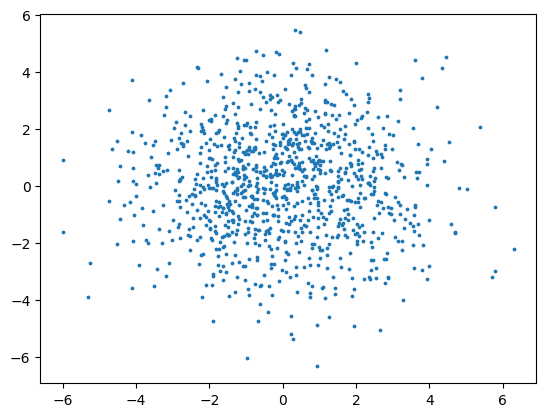

In [17]:
prior = MeanFreePrior(n_particles, spatial_dim, device=device, scale = noise_schedule.h(1) ** 0.5)
x1_samples = prior.sample(1024).detach().cpu()
plt.scatter(x1_samples[:, 0], x1_samples[:, 1], s=3)

print("prior samples", x1_samples.shape)

In [18]:
from src.models.components.prioritised_replay_buffer import SimpleBuffer
buffer = SimpleBuffer(
    dimensionality,
    10000,
    1000,
    initial_sampler=None,
    device=device,
    fill_buffer_during_init=False,
    sample_with_replacement=True,
    prioritize=False,
)

Buffer not initialised, expected that checkpoint will be loaded.


In [19]:
clipper = Clipper(
    should_clip_scores=False, should_clip_log_rewards=False, max_score_norm=20
)

In [20]:
t_switch_estimators = 0.7
outer_epochs= 100
inner_epochs = 100

batch_size = 32

x1_samples_energy = target(x1_samples.detach())
buffer.add(x1_samples, x1_samples_energy)

train_dataset = TensorDataset(x1_samples.detach(), x1_samples_energy.clone())
trainloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) 

num_mc_samples = 100

In [21]:
from src.models.components.egnn import EGNN_dynamics
score_net = EGNN_dynamics(n_particles=target.n_particles,
                          n_dimension=target.n_spatial_dim,
                          hidden_nf=32,
                          act_fn=torch.nn.SiLU(),
                          n_layers=3,
                          recurrent=True,
                          tanh=True,
                          attention=True,
                          condition_time=True,
                          agg='sum').to(device)


model = EnergyNet(score_net).to(device)
optimizer = Adam(model.parameters(), lr=1e-3)
weighted = False

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0 | Loss 4.820254
Epoch 49 | Loss 4.697015


/home/mila/t/tara.akhoundsadegh/scratch/demenv/lib/python3.10/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


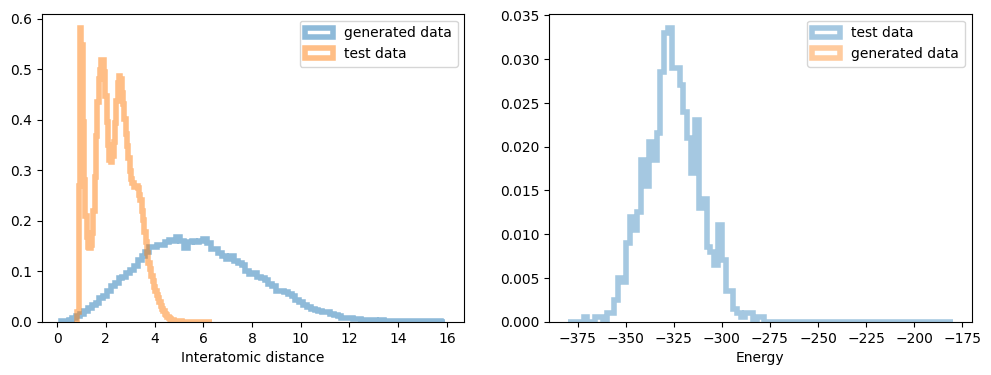

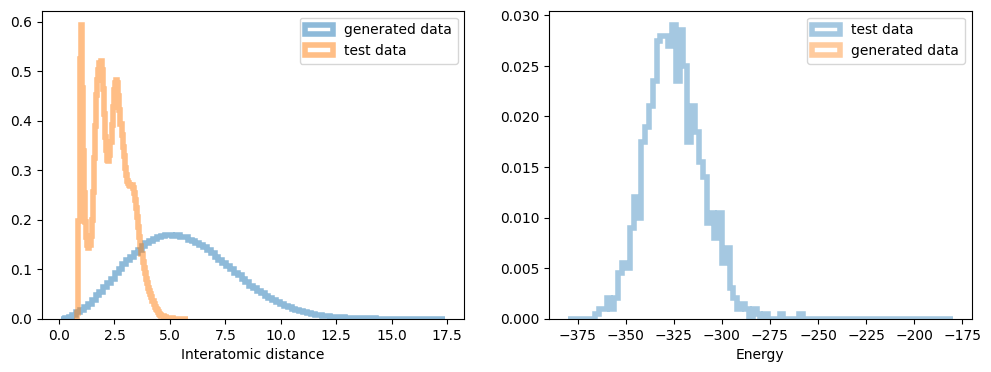

Epoch 98 | Loss 4.684186


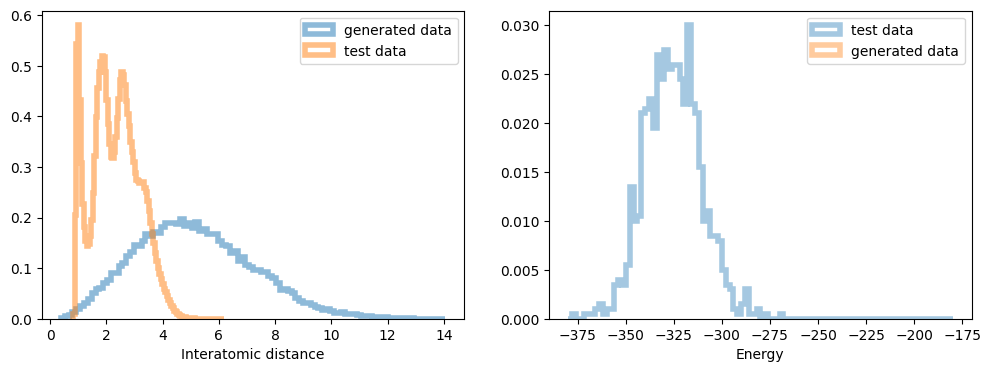

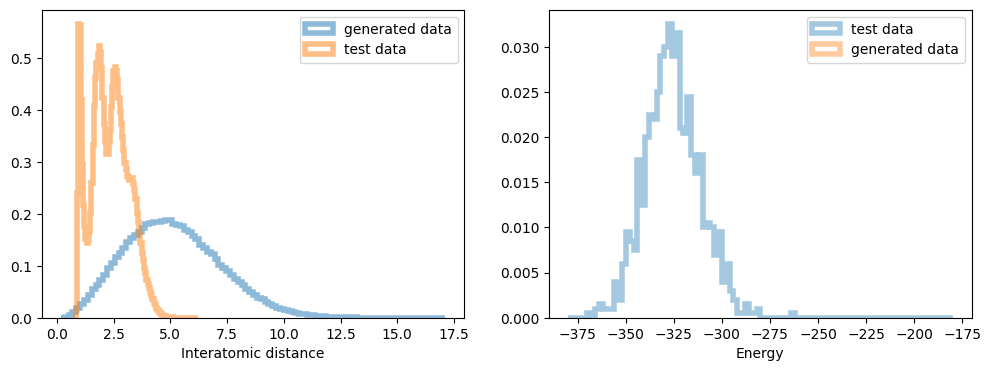

  1%|          | 1/100 [15:30<25:35:31, 930.62s/it]

Mean of Energy tensor(-69717.8906, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch 0 | Loss 4.527413
Epoch 49 | Loss 4.625667


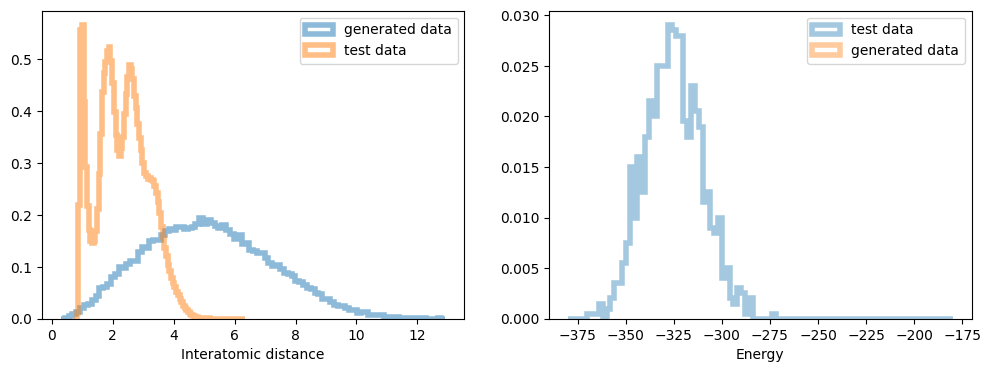

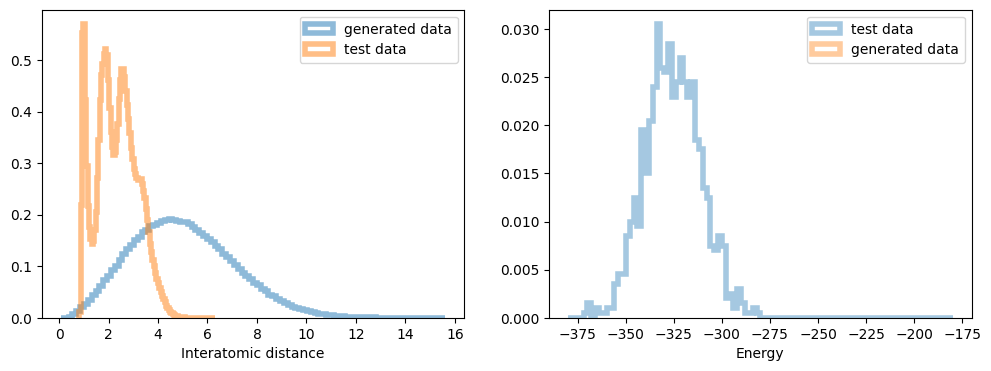

Epoch 98 | Loss 4.593001


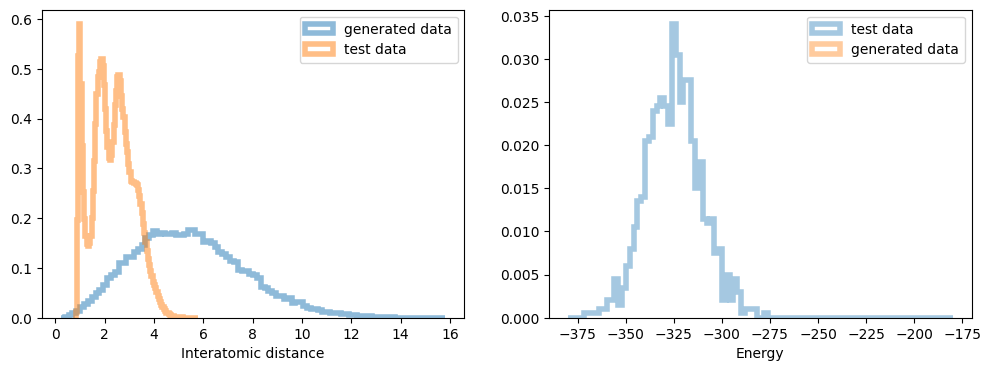

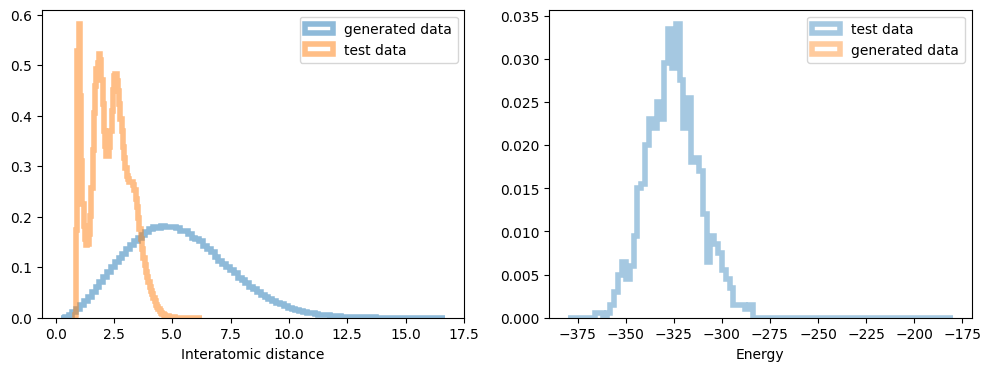

  2%|▏         | 2/100 [29:07<23:30:49, 863.77s/it]

Mean of Energy tensor(-48284.8594, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch 0 | Loss 4.679250
Epoch 49 | Loss 4.695285


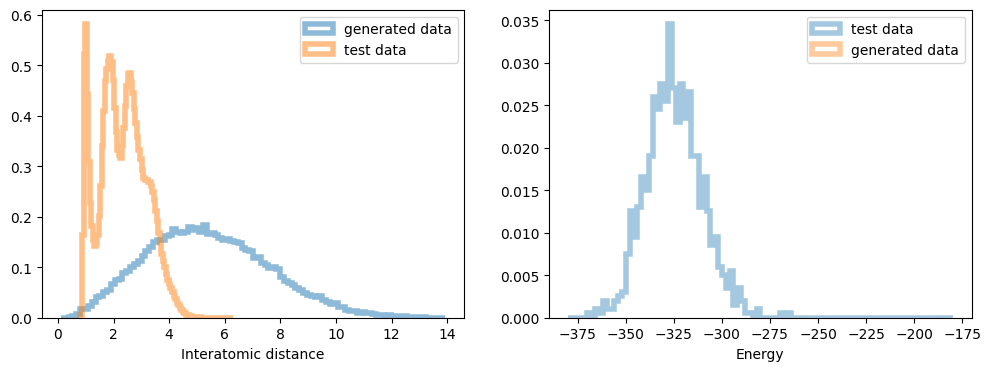

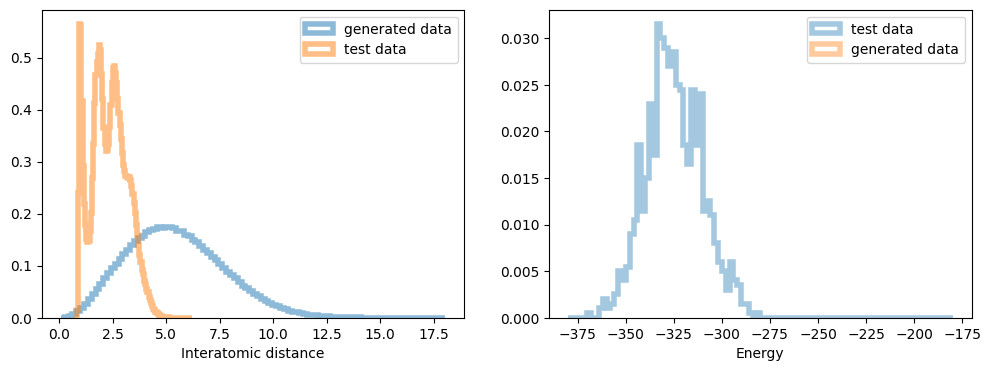

Epoch 98 | Loss 4.570497


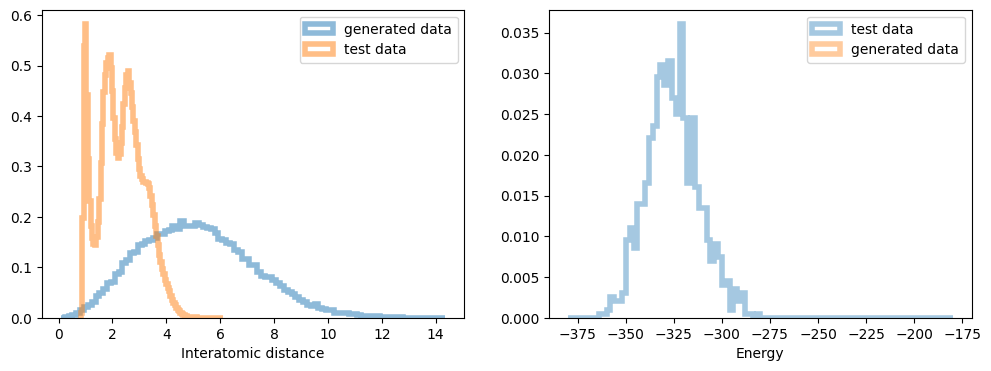

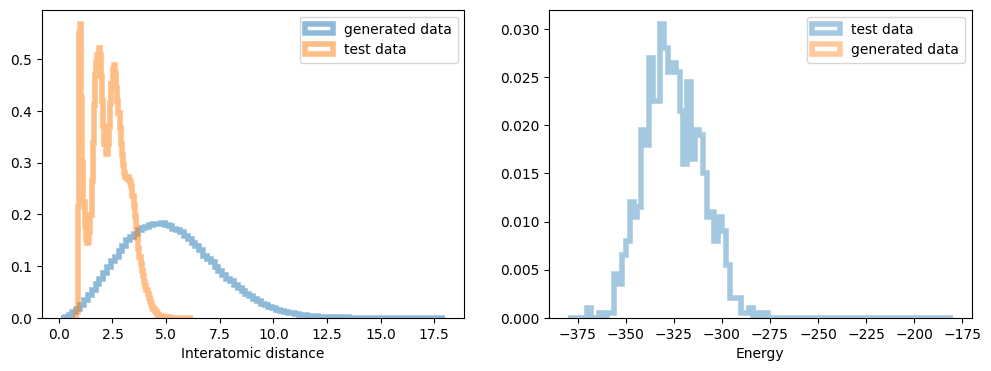

  3%|▎         | 3/100 [42:42<22:40:09, 841.34s/it]

Mean of Energy tensor(-401448.0625, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch 0 | Loss 4.575377
Epoch 49 | Loss 4.556114


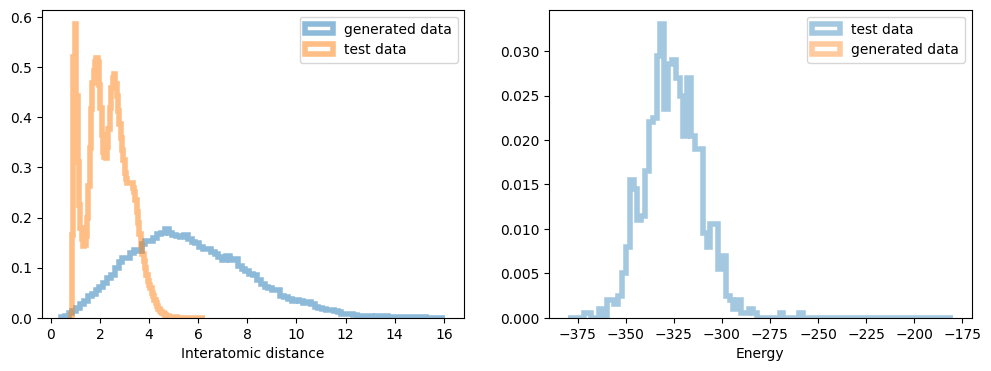

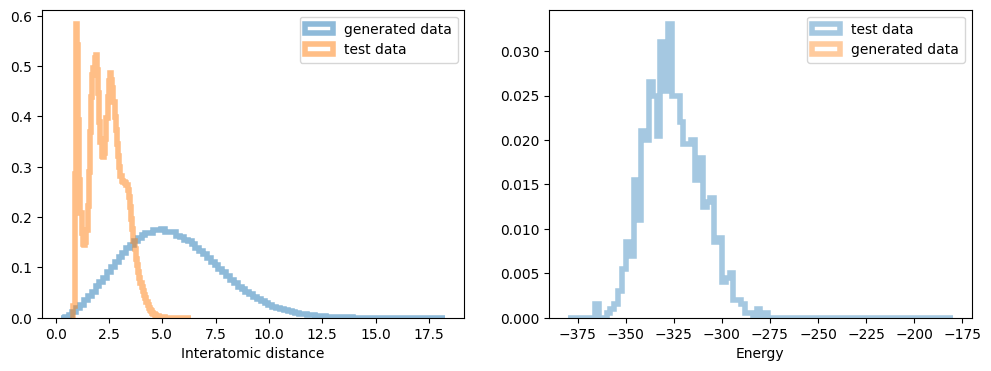

Epoch 98 | Loss 4.471115


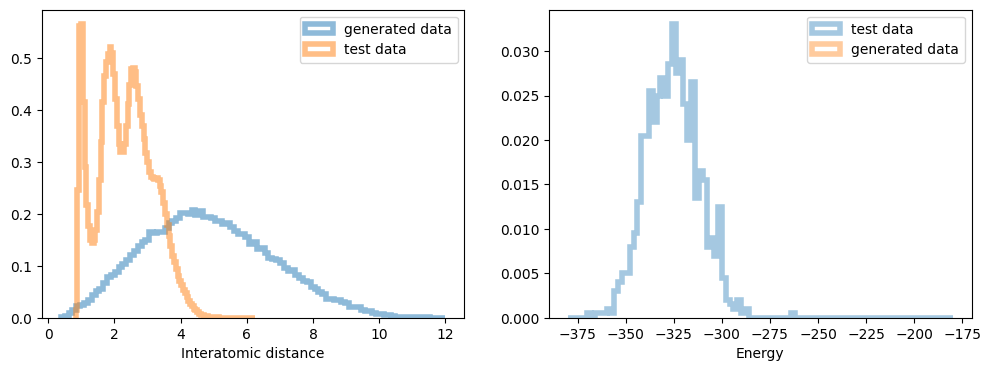

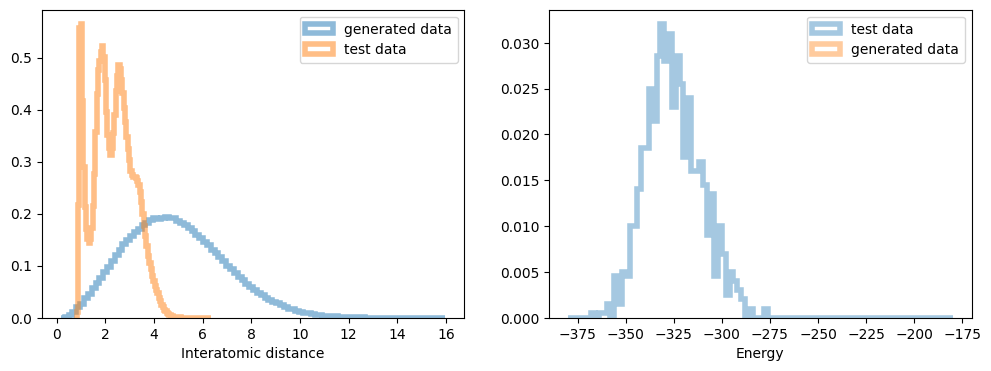

  4%|▍         | 4/100 [56:19<22:10:44, 831.72s/it]

Mean of Energy tensor(-12542.0713, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch 0 | Loss 4.536732
Epoch 49 | Loss 4.659008


In [27]:
for epoch in tqdm(range(outer_epochs)):
    for epoch in range(inner_epochs):
        total_loss = 0.
        for samples,_ in trainloader:
            samples = samples.to(device)

            samples_high_t = samples[:batch_size//2]
            samples_low_t = samples[batch_size//2:]
            
            optimizer.zero_grad()

            t = torch.rand(len(samples)).to(device)
            t_high = t[:batch_size//2] * (1-t_switch_estimators) + t_switch_estimators
            t_low = t[batch_size//2:] * t_switch_estimators

            rm_loss_high_t = reward_matching_loss(estimate_grad_Rt,
                                                  model, 
                                                  target,
                                                  samples_high_t,
                                                  t_high, 
                                                  samples,
                                                  noise_schedule, 
                                                  num_mc_samples=num_mc_samples,
                                                  ) 
            
            rm_loss_low_t = reward_matching_loss(estimate_grad_Rt,
                                                  model, 
                                                  target,
                                                  samples_low_t,
                                                  t_low, 
                                                  samples,
                                                  noise_schedule, 
                                                  num_mc_samples=num_mc_samples,
                                                  )
            

            
            loss = rm_loss_high_t.mean() + rm_loss_low_t.mean()
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            
        if epoch % 49 == 0:
            print("Epoch %d | Loss %f" % (epoch, loss.item()))

        if epoch % 49 == 0 and epoch > 0:
            samples_weighted = []
            for _ in range(1):
                ve_reverse_sde = VEReverse_coupled(model, noise_schedule)
                s, log_weights = generate_samples_weighted(ve_reverse_sde, 100, t_span=(0, 1), resampling_interval=1)
                samples_weighted.append(s)
            samples_weighted = torch.cat(samples_weighted, dim=0)
            target.get_dataset_fig(samples_weighted)
            plt.show()

            ve_reverse_sde = VEReverse_coupled(model, noise_schedule)
            samples, _ = generate_samples_weighted(ve_reverse_sde, 500, t_span=(0, 1), resampling_interval=None)

            target.get_dataset_fig(samples)
            plt.show()


    # Generate samples using the network
    ve_reverse_sde = VEReverse_coupled(model, noise_schedule)
    samples, log_weights = generate_samples_weighted(ve_reverse_sde, 100, t_span=(0, 1), resampling_interval=1)
    samples_energy = target(samples)

    # Update Buffer 
    buffer.add(samples, samples_energy)

    print("Mean of Energy", samples_energy.mean())
    
    # target.get_dataset_fig(samples)
    # plt.show()

    # Resample data from the buffer
    samples, samples_energy, _ = buffer.sample(batch_size * 10)
    train_dataset = TensorDataset(samples, samples_energy)
    trainloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)

In [ ]:
# Generate samples using the network
ve_reverse_sde = VEReverse_coupled(model, noise_schedule)
samples, log_weights = generate_samples_weighted(ve_reverse_sde, 1000, t_span=(0, 1))
samples_energy = target(samples)
print(log_weights.shape)

In [ ]:
log_weights[-1].exp().shape

In [ ]:
target.get_dataset_fig(samples, (-log_weights[-1]).exp().clamp(0, 1000));

In [ ]:
log_weights[-1].exp().clamp(0, 10)

In [ ]:
plt.plot(log_weights[:, :20].cpu())